In [1]:
#
import pandas as pd
import numpy as np
import json as json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
 # Loading the data from CSV into panadas dataframe
tempEarnings = pd.read_csv (r'../data/EARNINGS.csv', sep=',')
tempMonthly = pd.read_csv (r'../data/monthly-data.csv', sep=',')
TickerSymbols = pd.read_csv (r'../data/nasdaq_screener_sorted_values.csv', sep=',')

In [4]:
print(tempEarnings.shape)
print(tempEarnings.columns)
print(tempEarnings)

(15813, 7)
Index(['fiscalDateEnding', 'reportedDate', 'reportedEPS', 'estimatedEPS',
       'surprise', 'surprisePercentage', 'symbol'],
      dtype='object')
      fiscalDateEnding reportedDate reportedEPS estimatedEPS surprise  \
0           2021-09-30   2021-10-28        1.24        1.238    0.002   
1           2021-06-30   2021-07-27         1.3       1.0143   0.2857   
2           2021-03-31   2021-04-28         1.4       0.9888   0.4112   
3           2020-12-31   2021-01-27        1.68       1.4158   0.2642   
4           2020-09-30   2020-10-29        0.73       0.6987   0.0313   
...                ...          ...         ...          ...      ...   
15808       2001-05-31   2001-08-16        0.01         0.01        0   
15809       2001-02-28   2001-05-17        0.01         0.01        0   
15810       2000-11-30   2001-02-22        0.01         0.01        0   
15811       2000-08-31   2000-11-16        0.01         0.01        0   
15812       2000-05-31   2000-08-24   

In [5]:
# renaming Balance sheet column "fiscalDateEnding" to "timestamp" to match column name on both dataframes
tempEarnings = tempEarnings.rename(columns={"fiscalDateEnding": "timestamp"})


# Daily dates does not overlap on both dataframes, CompanyMonthly has the last trading day (not including weekends)
# While CompanyBalanaceSheet always has the last day of the month (including weekends)
# We need to cut out the daily date for both dataframes["timestamp"], to be able to merge them properly.
# Slicing the timestamp in CompanyMonthly, removing the days
sliceMonthly = tempMonthly["timestamp"].str.slice(0, -3)
tempMonthly["timestamp"] = sliceMonthly

# Printing
print(tempMonthly["timestamp"])

# Slicing the timestamp in CompanyBalanceSheet, removing the days
sliceEarnings = tempEarnings["timestamp"].str.slice(0, -3)
# For some reason i needed to use Iloc here, don't know why... 
tempEarnings["timestamp"] = sliceEarnings

# Printing
print(tempEarnings["timestamp"])

# printing
print(TickerSymbols["Symbol"])
    

0        2021-11
1        2021-10
2        2021-09
3        2021-08
4        2021-07
          ...   
43662    2000-11
43663    2000-10
43664    2000-09
43665    2000-08
43666    2000-07
Name: timestamp, Length: 43667, dtype: object
0        2021-09
1        2021-06
2        2021-03
3        2020-12
4        2020-09
          ...   
15808    2001-05
15809    2001-02
15810    2000-11
15811    2000-08
15812    2000-05
Name: timestamp, Length: 15813, dtype: object
0       AAPL
1       MSFT
2       GOOG
3      GOOGL
4       AMZN
       ...  
195     STLA
196      NIO
197      UBS
198     CRWD
199     MRVL
Name: Symbol, Length: 200, dtype: object


In [7]:
# for each company we want to make adjustments needed for each companys features and then we will merge them into one df

#------------ add error if ticker symbol is not in TickerSymbols["Symbol"] or size < 200


TickerSymbols = TickerSymbols[~TickerSymbols['Symbol'].isin(['RIVN'])]
final_df = pd.DataFrame()
counter = 0

for tickerSymbol in TickerSymbols["Symbol"]:
    counter = counter +1
    print("this is the beginning of the forloop, tickersymbol: " + tickerSymbol + "counter = " + str(counter))
    
    # filter both dataframes to only use a certain stock, in this case Apple (AAPL)
    CompanyEarnings = tempEarnings.loc[tempEarnings["symbol"] == tickerSymbol]
    CompanyMonthly = tempMonthly.loc[tempMonthly["Symbol"] == tickerSymbol]
    
    # printing
    #print(CompanyIncomestatement)
    #print(CompanyMonthly)
    
    # Cutting out unecessary data from the CompanyMonthly
    # We only need price data in CompanyMonthly within the daterange of the 20 rows on CompanyBalanceSheet data
    # every row is 3 months in CompanyBalanceSheet. Every row in CompanyMonthly is 1 month, 3x20 = 60.
    idx = (CompanyMonthly.index[0]+60)
    CompanyMonthly = CompanyMonthly.loc[:idx]

    # printing
    #print(CompanyMonthly.shape)
    
    # merging the rows from balance sheet and monthly on timestamp.
    merged_df = pd.merge(CompanyEarnings, CompanyMonthly, how="outer", on = "timestamp")

    # Printing
    #print(merged_df.head(21))
    
    # removing the rows over 20
    merged_df = merged_df.loc[:19]

    # calculate how much the increase is in percentage, interval of 3 months
    # also offsetting by 1, to get the labels on the correct row.
    cat = ["timestamp", "symbol", "close", "change"]
    merged_df["change"] = merged_df["close"].pct_change(periods = -1).shift(periods = 1)
    #print("This is the data for: " + tickerSymbol)    
    #print(merged_df[cat].head(20))
    
    # Removing the first row, because we do not have a label for it, 3 months have not passed yet for us to get the end price of the 3 month cycle
    merged_df.drop(index=merged_df.index[0], axis=0, inplace=True)
    #print(merged_df[cat].head(25))
    
    # Check datatypes in dataframe
    #print(merged_df.dtypes)

    # Also dropping columns that we do not need, symbol, Symbol, open, high, low, close, volume etc.
    merged_df.drop(['symbol', 'Symbol', 'open','high','low','close','volume',"timestamp", "reportedDate"], axis=1, inplace=True)

    # replacing all "None" strings with NaN data type
    merged_df = merged_df.replace('None', np.nan)

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]
    #print(sub_df)

    # Casting all values to floats to calculate coffeicent and confusion matrix
    #merged_df = merged_df.astype("float64")
    #print(merged_df.dtypes)

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]
    print(sub_df)
    
    for col in merged_df.columns:
        if col != "timestamp":
            merged_df[col] = merged_df[col].astype("float")
            merged_df[col] = merged_df[col].replace(np.nan, merged_df[col].mean())
        #print("Column name: " + col + ", has mean value: " + str(merged_df[col].mean()))
    #print(merged_df.isnull().values.any())
    #print(merged_df.head())
    
    # adding it to the final dataframe
    final_df = pd.concat([final_df, merged_df], axis=0)
    #final_df.append(merged_df, ignore_index=True)

    # Make new cell where we calculated the number of "none"/NA/NaN values for each feature (column in balancesheet)

this is the beginning of the forloop, tickersymbol: AAPLcounter = 1
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: MSFTcounter = 2
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: GOOGcounter = 3
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: GOOGLcounter = 4
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: AMZNcounter = 5
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: TSLAcounter = 6
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: NVScounter = 55
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: UPScounter = 56
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: INTUcounter = 57
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: TXNcounter = 58
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: AZNcounter = 59
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tic

Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: GEcounter = 109
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: CATcounter = 110
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: SQcounter = 111
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: ZTScounter = 112
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: PDDcounter = 113
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, t

this is the beginning of the forloop, tickersymbol: WDAYcounter = 164
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: MCOcounter = 165
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: EWcounter = 166
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: CIcounter = 167
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: BDXcounter = 168
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: MELIcounter = 169
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

In [8]:
print(final_df)
print(final_df.columns)
print(final_df.dtypes)

    reportedEPS  estimatedEPS  surprise  surprisePercentage    change
1          1.30        1.0143    0.2857             28.1672  0.033148
2          1.40        0.9888    0.4112             41.5858  0.121244
3          1.68        1.4158    0.2642             18.6608 -0.079433
4          0.73        0.6987    0.0313              4.4797  0.145756
5          0.65        0.5100    0.1400             27.4510 -0.682538
..          ...           ...       ...                 ...       ...
15         0.34        0.3264    0.0136              4.1667  0.311558
16         0.30        0.2805    0.0195              6.9519  0.038863
17         0.24        0.2131    0.0269             12.6232  0.105128
18         0.20        0.1191    0.0809             67.9261  0.000000
19         0.01        0.0651   -0.0551            -84.6390  0.000000

[3748 rows x 5 columns]
Index(['reportedEPS', 'estimatedEPS', 'surprise', 'surprisePercentage',
       'change'],
      dtype='object')
reportedEPS           f

In [12]:
print(final_df.head(50))

    reportedEPS  estimatedEPS  surprise  surprisePercentage    change
1        1.3000        1.0143    0.2857             28.1672  0.033148
2        1.4000        0.9888    0.4112             41.5858  0.121244
3        1.6800        1.4158    0.2642             18.6608 -0.079433
4        0.7300        0.6987    0.0313              4.4797  0.145756
5        0.6500        0.5100    0.1400             27.4510 -0.682538
6        0.6400        0.5600    0.0800             14.2857  0.434583
7        1.2500        1.1400    0.1100              9.6491 -0.134037
8        0.7600        0.7100    0.0500              7.0423  0.311113
9        0.5500        0.5300    0.0200              3.7736  0.131619
10       0.6200        0.5900    0.0300              5.0847  0.041958
11       1.0500        1.0400    0.0100              0.9615  0.204197
12       0.7300        0.7000    0.0300              4.2857 -0.301232
13       0.5850        0.5450    0.0400              7.3394  0.219491
14       0.6825     

change                1.000000
surprisePercentage    0.059940
surprise             -0.003931
estimatedEPS         -0.030813
reportedEPS          -0.087917
Name: change, dtype: float64


<AxesSubplot:>

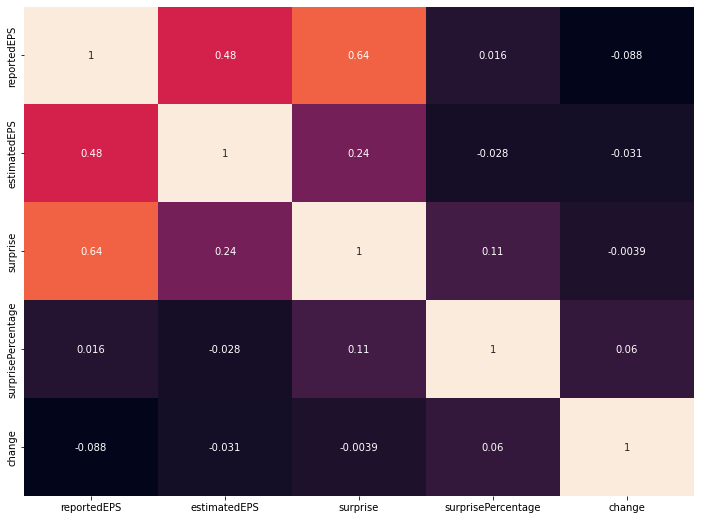

In [13]:
# correlation calculation
feature_corr = final_df.copy().corr()

# Then, print correlation of 'Sale Price' with other features from 'feature_corr' and sort  in descending order
#  ===== YOUR CODE HERE ==========
sortedDesc = feature_corr["change"].sort_values(ascending=False) 
print(sortedDesc)

#cf_matrix = confusion_matrix(feature_corr)
plt.figure(figsize = (12,9))
sns.heatmap(feature_corr, annot=True, cbar=False, )